In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

In [2]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.9
maxh = 0.01

numSheets = 10



## Reference Solution

In [4]:
from meshGen import mesh2DLaminates
meshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, modelHalfAir=True).mesh
Draw(meshRef.ngmesh)
print(set(meshRef.GetMaterials()))

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

{'inner', 'insulation', 'outer'}


In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "multiscale":lambda2}, default=lambda1)
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 3.825855781256528     
CG iteration 2, residual = 1.0588168112043437e-12     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw(lam * grad(sol_ref)[0], meshRef, max = 150, min = 0)

energy:	0.5919583931698202


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## Multiscale

In [7]:
modelHalfAir=True

cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir)
meshMS = cMeshMS.mesh
Draw(meshMS.ngmesh)

print(meshMS.GetMaterials())

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

('outer', 'multiscale')


In [8]:

cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 0

from cempy.phiFunctions import Lobatto, dxLobatto
cl_Phi.phiFunction = Lobatto
cl_Phi.dzPhiFunction = dxLobatto


def calcMultiscale(useGradients=True, darwPhis=True):


    # microshape functions
    orderPhi = [
            cl_Phi(1, fes_order=0, material="multiscale", useGradients=useGradients), 
        ]

    if darwPhis:
        cl_Phi.plotEvaluated(orderPhi)

    VSpace = []
    # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="right|left")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material)))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1) * dx("multiscale")


    prec = Preconditioner(a,type="direct")  




    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    print(a.mat.AsVector().Norm())

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, definedon=meshMS.Materials("multiscale"))
    
    return sol, cl_gradgradMS.gradsol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS


    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp,    energy_MS, cl_gradgradMS = calcMultiscale(useGradients=False, darwPhis=False)

print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print(energy_MS)


CG iteration 1, residual = 3.6763636575457435     
CG iteration 2, residual = 3.996750835716484e-13     
113614.98545290789
9.7216396208047e-07
0.6074688112347917


In [9]:
if False:
    from cempy.phiFunctions import Lobatto, dxLobatto
    cl_Phi.phiFunction = Lobatto
    cl_Phi.dzPhiFunction = dxLobatto


    a = cl_Phi(2, 1, phiFunction=Lobatto, dxPhiFunction=dxLobatto, inAir=False)
    b = cl_Phi(2, 1, phiFunction=pyLobatto, dxPhiFunction=pydxLobatto, inAir=False)

    print(a.phi.xStart, b.phi.xStart)


    print(getPhiPhiValue(a.phi, a.phi, 1, 1, force_num_int=True))
    print(getPhiPhiValue(b.phi, b.phi, 1, 1, force_num_int=True))

    print(a.phi.DirectEvaluate(0))
    print(b.phi.DirectEvaluate(0))

    xi= np.linspace(-d/2*1.1, d/2*1.1, 200000)
    yi_a = [a.phi.DirectEvaluate(x) for x in xi]
    yi_b = [b.phi.DirectEvaluate(x) for x in xi]

    print("test", cl_Phi.dFe/2, b.phi.map2sheet(b.phi.xStart + cl_Phi.dFe/2 ))

    print(a.phi.d)
    plt.figure(10)
    plt.clf()
    plt.plot(xi, yi_a, label="c++")
    plt.plot(xi, yi_b, label="python")
    plt.legend()
    plt.pause(0.1)



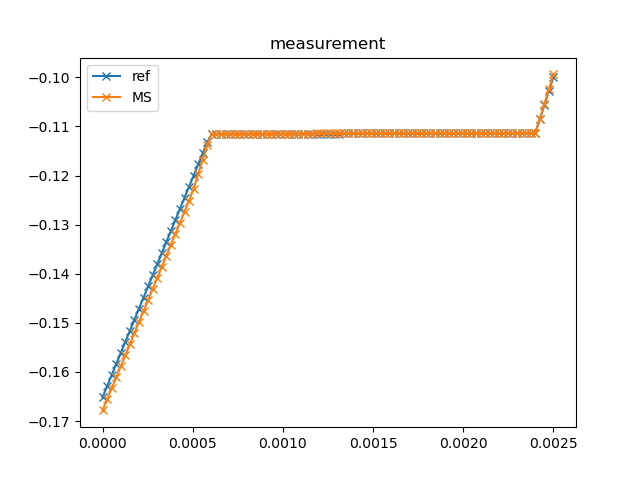

In [10]:
from myPackage import evalOnLine

start = -d/2*1.05
end =-d/2*0.8

# start = -D/2
# end = D/2
evalOnLine(sol_ref , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="x", show=False, label="ref");
evalOnLine(sum(sol_comp_MS) , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="x", clear=False, label="MS", show=False);
plt.legend()
plt.show()


In [11]:
Draw(sum(sol_comp_MS) , meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

In [12]:
Draw(-lam * sum(H_comp)[0], meshRef, min = 0, max=150, settings={"Objects":{"Wireframe":False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [13]:
Draw(lam * grad(sol_ref)[0], meshRef, min = 0, max=150, settings={"Objects":{"Wireframe":False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [14]:
print("energy multiscale", energy_MS)
print("energy reference", energy_ref)

energy multiscale 0.6074688112347917
energy reference 0.5919583931698202
